# Preprocessing steps for _isMuon_ models

In [1]:
LOCAL = True
SAMPLE = "2016MU"

## Technologies and libraries

On top of the standard Python echosystem we are using:
 * `uproot` to convert data from `ROOT TTrees` to `pandas DataFrames`
 * `dask DataFrame` to enable processing datasets larger than the available RAM. Dask takes care of flushing from disk to RAM the data, converting from ROOT to pandas data format on demand.
 * `Arrow Feather` data format to cache in local storage the training dataset
     * Note that custom wrappers to Dask and TensorFlow, as defined in `feather_io.py` are needed 

In [2]:
import uproot
import numpy as np
import pandas as pd
import dask.dataframe as ddf

from os import environ

## Loading data

In [3]:
from glob import glob

if LOCAL:
    if SAMPLE == "2016MU":
        file_pattern = "/afs/cern.ch/user/l/landerli/gangadir/workspace/landerli/LocalXML/109/*/output/*.root"
    else:
        pass
else:
    # file_pattern = "/workarea/cloud-storage/anderlinil/LamarrBenderTrain/j109/*.root"
    pass

default_file_list = glob(file_pattern)
file_list = environ.get("INPUT_FILES", " ".join(default_file_list)).split(" ")

print (f"Found {len(file_list)} files from {file_pattern}")  

Found 236 files from /afs/cern.ch/user/l/landerli/gangadir/workspace/landerli/LocalXML/109/*/output/*.root


### Conversion from `ROOT TTree` to `Pandas DataFrame`

In [4]:
def read_root(filename, tree=None):
    if tree is None:
        return uproot.open(filename)
    
    return pd.DataFrame(uproot.open(filename)[tree].arrays(library='np'))

In [5]:
selections = [
  "probe_Brunel_ETA > 1.5",
  "probe_Brunel_ETA < 5.5",
  "nTracks_Brunel > 0",
  "nTracks_Brunel < 1000",
  "probe_Brunel_MuonUnbiased == 1",
]

cuts = " and ".join([f"({s})" for s in selections])

In [6]:
from functools import partial

sim = dict()
particles = ["muon", "pion", "kaon", "proton"]

for part in particles:
    sim[part] = (
        ddf.from_map(
            partial(read_root, tree=f"PidTupler/pid_{part}"),
            file_list,
        ).query(cuts)
    )

### List of features

In [7]:
from IPython.display import HTML

HTML ("<UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in sim["muon"].columns) + "</UL>")

## Features

In [8]:
for part in particles:
    sim[part]["p_GeV"] = sim[part].probe_Brunel_P/1e3
    # sim[part]["log10_p"] = np.log10(sim[part].probe_Brunel_P)
    sim[part]["eta"] = sim[part].probe_Brunel_ETA
    sim[part] = sim[part].map_partitions(lambda df: df.assign(nTracks_f = df.nTracks_Brunel + np.random.uniform(-0.5, 0.5, len(df))))
    sim[part]["charge"] = sim[part].probe_Brunel_trackcharge
    
    sim[part]["isMuon"] = sim[part].probe_Brunel_isMuon

In [9]:
real_features = ["p_GeV", "eta", "nTracks_f"]
flag_features = ["charge"]

features = real_features + flag_features
labels = ["isMuon"]

In [10]:
from IPython.display import HTML

def list_vars(title, var_list):
    display(HTML (f"<P><B>{title}</B><UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in var_list) + "</UL><HR>"))

list_vars("Input features (real)", real_features)
list_vars("Input features (boolean)", flag_features)
list_vars("Output features (real)", labels)

In [11]:
dfs = dict()

for part in particles:
    dfs[part] = sim[part][features + labels].head(500_000, npartitions=10)
    print(f"Number of {part}s:", len(dfs[part]))

Number of muons: 500000
Number of pions: 500000
Number of kaons: 500000
Number of protons: 500000


### Histograms

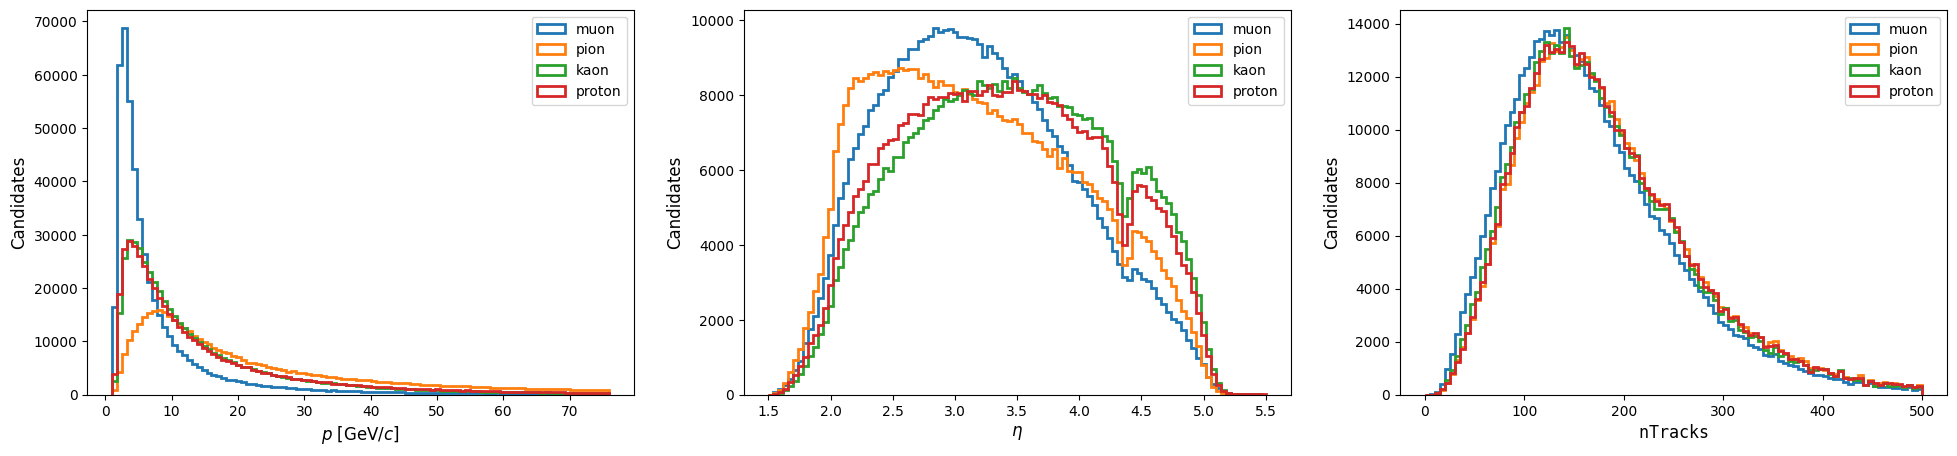

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 5), dpi=100)

plt.subplot(1, 3, 1)
plt.xlabel("$p$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs[part]["p_GeV"], bins=np.linspace(1.0, 76.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(1, 3, 2)
plt.xlabel("$\eta$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs[part]["eta"], bins=np.linspace(1.5, 5.5, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(1, 3, 3)
plt.xlabel("$\mathtt{nTracks}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs[part]["nTracks_f"], bins=np.linspace(0.0, 500.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.show()

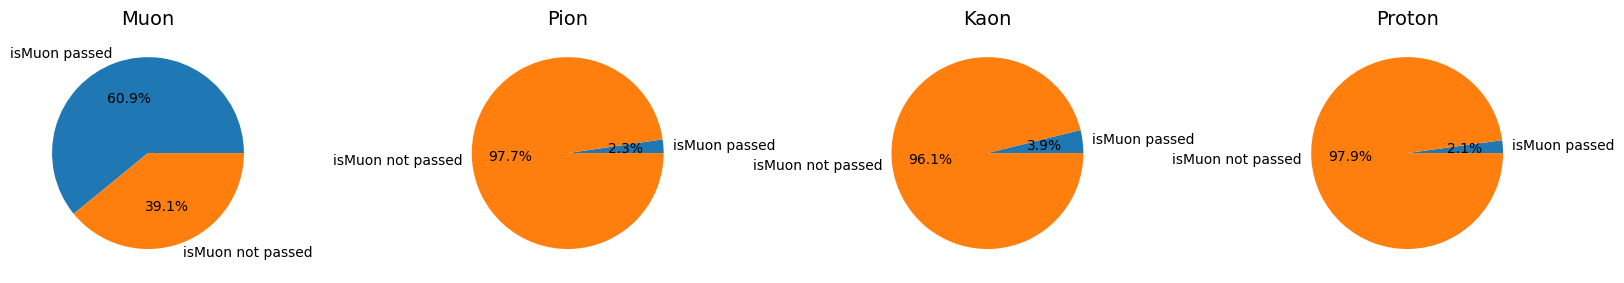

In [13]:
plt.figure(figsize=(16, 3))

for i, part in enumerate(particles):
  plt.subplot(1, 4, i+1)
  plt.title(part.capitalize(), fontsize=14)

  categories = [np.count_nonzero(dfs[part]["isMuon"].values)]
  categories.append(len(dfs[part]) - sum(categories))

  plt.pie(categories, autopct="%1.1f%%", labels=["isMuon passed", "isMuon not passed"])

plt.tight_layout()
plt.show()

## Preprocessing

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer

n_features = len(real_features)
n_flags = len(flag_features)

prep_step = dict()
for part in particles:
    prep_step[part] = ColumnTransformer(
        [
            ('features', QuantileTransformer(output_distribution='normal'), np.arange(n_features)),
            ('flags', "passthrough", n_features + np.arange(n_flags)),
        ]
    ).fit(dfs[part][features].values)

In [15]:
from preprocessing_utils import store_as_pickle

for part in particles:
    display(
        store_as_pickle(
            prep_step[part],
            f"ISMUON_{part.upper()}_PREPROCESSING",
            f"/home/mabarbet/PythonFastSim/models/isMuon_{part}_models/tX_{SAMPLE}.pkl",
        )
    )

2023-12-28 00:16:56.330578: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 00:16:56.330635: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 00:16:56.330682: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 00:16:56.344475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train, test and validation

The dataset is split in:
 * *train* (50%) used for training the model
 * *test* (40%) used for measuring the performance of the model
 * *validation* (10%) used in combination with the train dataset to check for overtraining effects
 
Split data is stored on disk in chunks of 100 MB (before compression).

In [16]:
DATA_PATH = "/home/mabarbet/PythonFastSim/data" if LOCAL else "/workarea/cloud-storage/mabarbet/data"

### Muons

In [17]:
from preprocessing_utils import split_and_store

entries = split_and_store(
    sim["muon"][features + labels],
    [
        (0.5, environ.get("ISMUON_MUON_TRAIN", f"{DATA_PATH}/isMuon-muon-{SAMPLE}-train")),
        (0.4, environ.get("ISMUON_MUON_TEST", f"{DATA_PATH}/isMuon-muon-{SAMPLE}-test")),
        (0.1, environ.get("ISMUON_MUON_VALIDATION", f"{DATA_PATH}/isMuon-muon-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=features,
    labels=labels,
    preprocessorX=prep_step["muon"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/isMuon-muon-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/isMuon-muon-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/isMuon-muon-2016MU-validation


,0
Train,19583180
Test,15668882
Validation,3914729


In [18]:
from feather_io import FeatherReader    

reader_train =  FeatherReader(environ.get("ISMUON_MUON_TRAIN", f"{DATA_PATH}/isMuon-muon-{SAMPLE}-train"), max_files=3)
ds_train_mu = reader_train.as_tf_dataset()

In [19]:
X_mu, y_mu = next(iter(ds_train_mu.batch(2_000_000)))
X_mu.shape, y_mu.shape

(TensorShape([2000000, 4]), TensorShape([2000000, 1]))

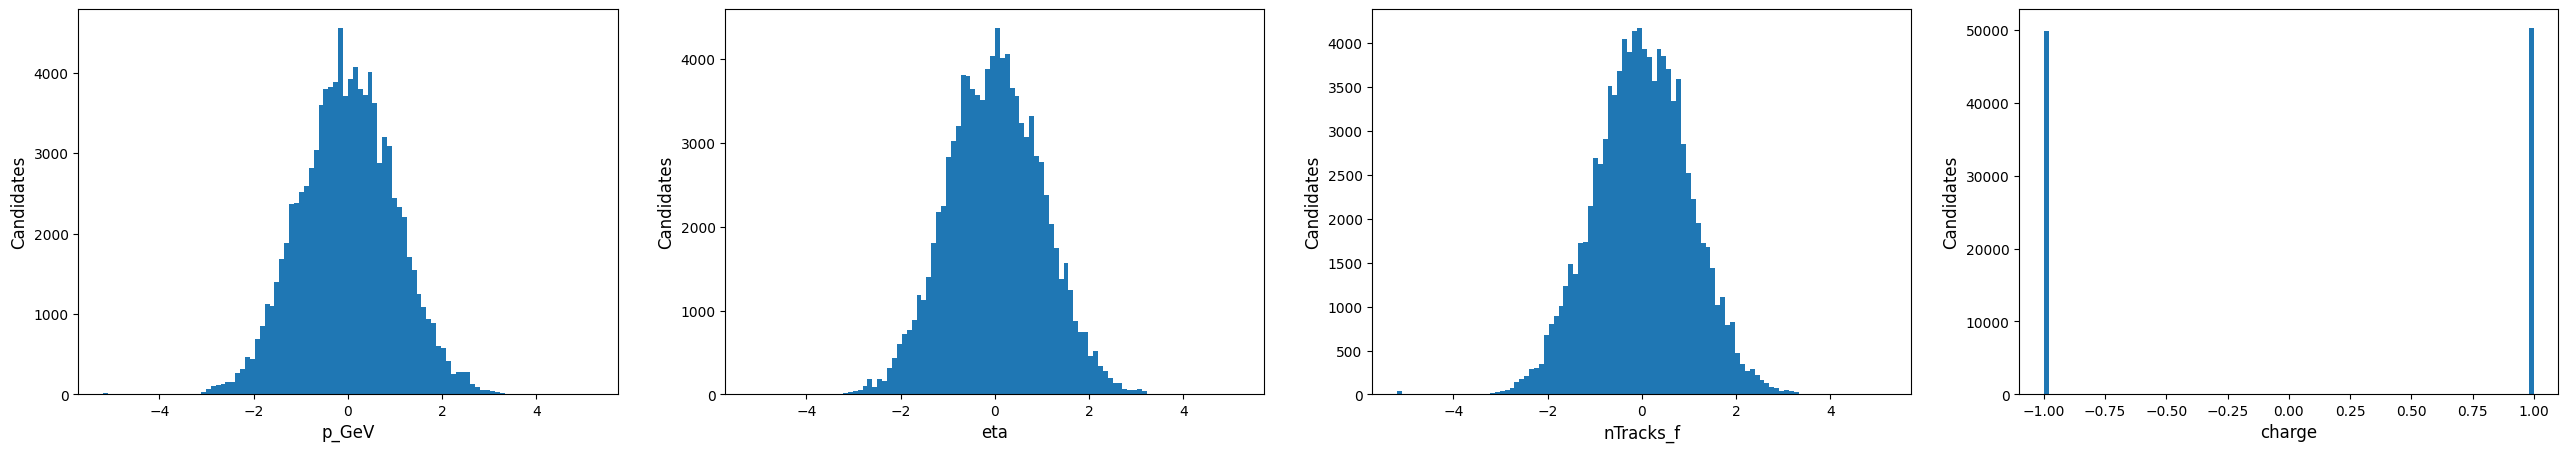

In [20]:
plt.figure(figsize=(32, 5), dpi=100)

for i, x_var in enumerate(features):
    plt.subplot(1, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_mu[:, i].numpy()[:100000], bins=100)

plt.show()

In [21]:
np.savez_compressed(
    file=f"{DATA_PATH}/isMuon-muon-{SAMPLE}-trainset.npz",
    x=X_mu.numpy(),
    x_vars=features,
    y=y_mu.numpy(),
    y_vars=labels,
    w=None,
    w_var=None,
)

### Pions

In [22]:
entries = split_and_store(
    sim["pion"][features + labels],
    [
        (0.5, environ.get("ISMUON_PION_TRAIN", f"{DATA_PATH}/isMuon-pion-{SAMPLE}-train")),
        (0.4, environ.get("ISMUON_PION_TEST", f"{DATA_PATH}/isMuon-pion-{SAMPLE}-test")),
        (0.1, environ.get("ISMUON_PION_VALIDATION", f"{DATA_PATH}/isMuon-pion-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=features,
    labels=labels,
    preprocessorX=prep_step["pion"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/isMuon-pion-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/isMuon-pion-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/isMuon-pion-2016MU-validation


,0
Train,57026879
Test,45630764
Validation,11405807


In [23]:
reader_train =  FeatherReader(environ.get("ISMUON_PION_TRAIN", f"{DATA_PATH}/isMuon-pion-{SAMPLE}-train"), max_files=5)
ds_train_pi = reader_train.as_tf_dataset()

In [24]:
X_pi, y_pi = next(iter(ds_train_pi.batch(2_000_000)))
X_pi.shape, y_pi.shape

(TensorShape([2000000, 4]), TensorShape([2000000, 1]))

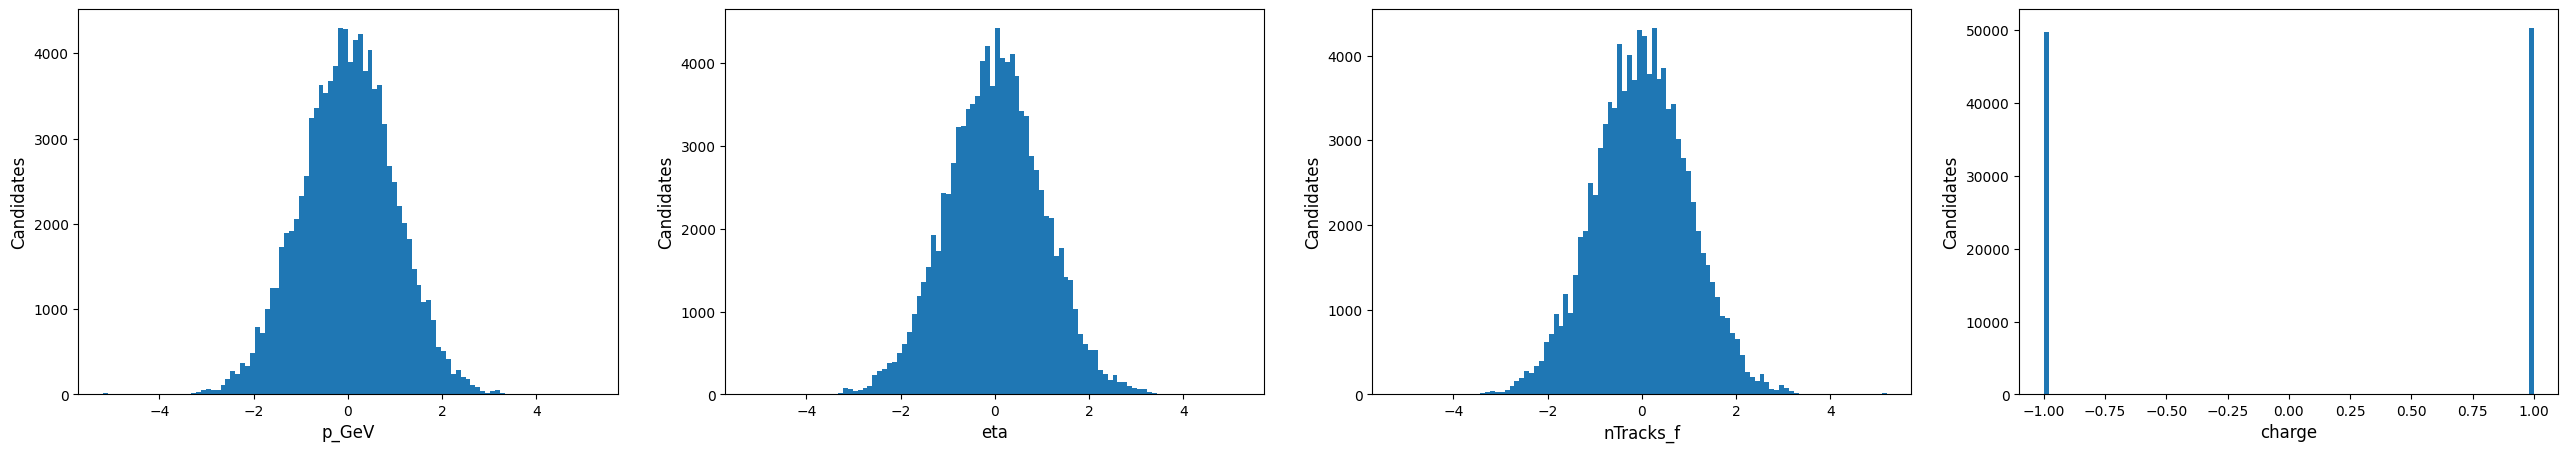

In [25]:
plt.figure(figsize=(32, 5), dpi=100)

for i, x_var in enumerate(features):
    plt.subplot(1, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_pi[:, i].numpy()[:100000], bins=100)

plt.show()

In [26]:
np.savez_compressed(
    file=f"{DATA_PATH}/isMuon-pion-{SAMPLE}-trainset.npz",
    x=X_pi.numpy(),
    x_vars=features,
    y=y_pi.numpy(),
    y_vars=labels,
    w=None,
    w_var=None,
)

### Kaons

In [27]:
entries = split_and_store(
    sim["kaon"][features + labels],
    [
        (0.5, environ.get("ISMUON_KAON_TRAIN", f"{DATA_PATH}/isMuon-kaon-{SAMPLE}-train")),
        (0.4, environ.get("ISMUON_KAON_TEST", f"{DATA_PATH}/isMuon-kaon-{SAMPLE}-test")),
        (0.1, environ.get("ISMUON_KAON_VALIDATION", f"{DATA_PATH}/isMuon-kaon-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=features,
    labels=labels,
    preprocessorX=prep_step["kaon"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/isMuon-kaon-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/isMuon-kaon-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/isMuon-kaon-2016MU-validation


,0
Train,100151865
Test,80123673
Validation,20030833


In [28]:
reader_train =  FeatherReader(environ.get("ISMUON_KAON_TRAIN", f"{DATA_PATH}/isMuon-kaon-{SAMPLE}-train"), max_files=3)
ds_train_k = reader_train.as_tf_dataset()

In [29]:
X_k, y_k = next(iter(ds_train_k.batch(2_000_000)))
X_k.shape, y_k.shape

(TensorShape([2000000, 4]), TensorShape([2000000, 1]))

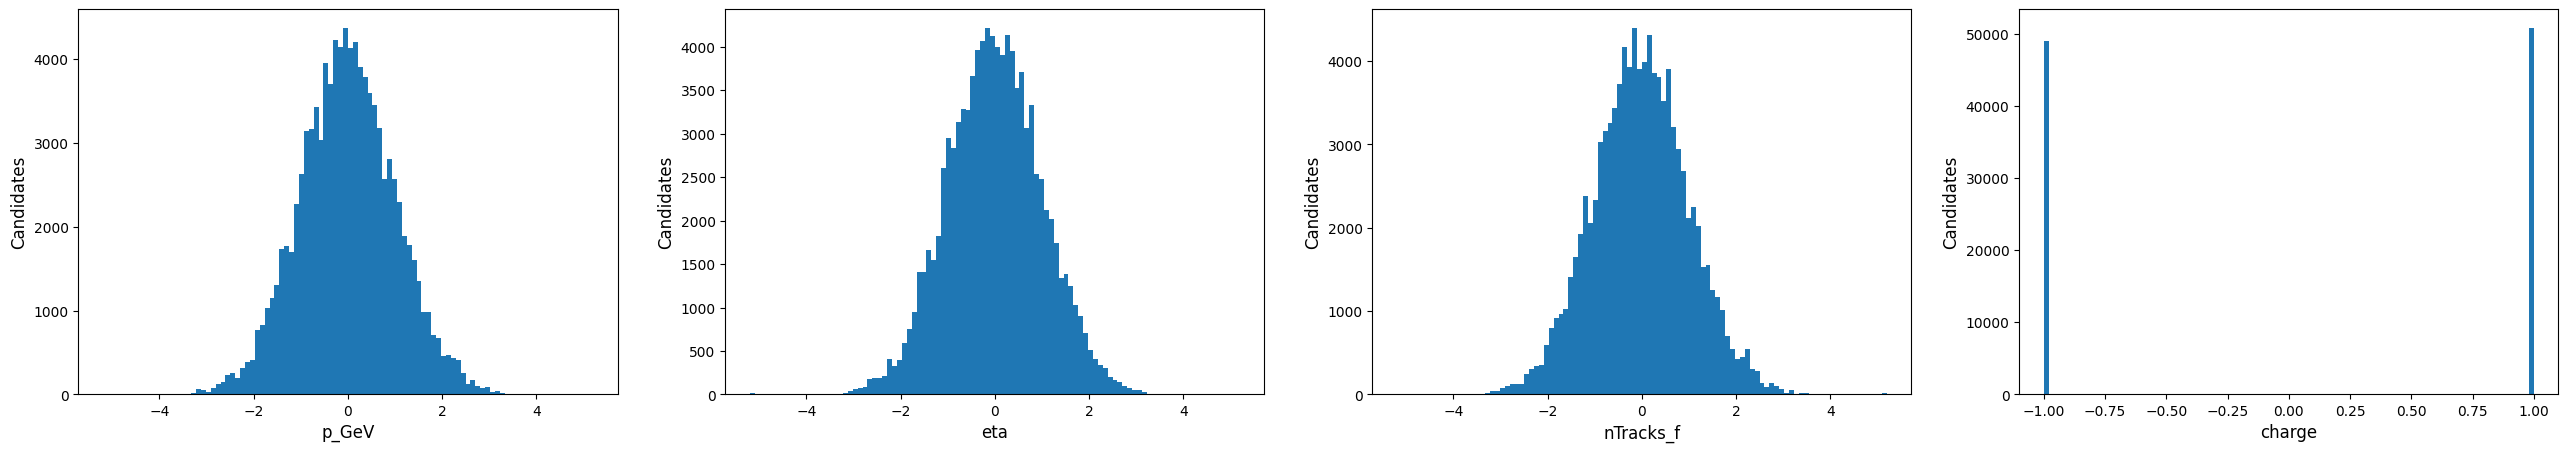

In [30]:
plt.figure(figsize=(32, 5), dpi=100)

for i, x_var in enumerate(features):
    plt.subplot(1, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_k[:, i].numpy()[:100000], bins=100)

plt.show()

In [31]:
np.savez_compressed(
    file=f"{DATA_PATH}/isMuon-kaon-{SAMPLE}-trainset.npz",
    x=X_k.numpy(),
    x_vars=features,
    y=y_k.numpy(),
    y_vars=labels,
    w=None,
    w_var=None,
)

### Protons

In [32]:
entries = split_and_store(
    sim["proton"][features + labels],
    [
        (0.5, environ.get("ISMUON_PROTON_TRAIN", f"{DATA_PATH}/isMuon-proton-{SAMPLE}-train")),
        (0.4, environ.get("ISMUON_PROTON_TEST", f"{DATA_PATH}/isMuon-proton-{SAMPLE}-test")),
        (0.1, environ.get("ISMUON_PROTON_VALIDATION", f"{DATA_PATH}/isMuon-proton-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=features,
    labels=labels,
    preprocessorX=prep_step["proton"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/isMuon-proton-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/isMuon-proton-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/isMuon-proton-2016MU-validation


,0
Train,72521344
Test,58013150
Validation,14512103


In [33]:
reader_train =  FeatherReader(environ.get("ISMUON_PROTON_TRAIN", f"{DATA_PATH}/isMuon-proton-{SAMPLE}-train"), max_files=3)
ds_train_p = reader_train.as_tf_dataset()

In [34]:
X_p, y_p = next(iter(ds_train_p.batch(2_000_000)))
X_p.shape, y_p.shape

(TensorShape([2000000, 4]), TensorShape([2000000, 1]))

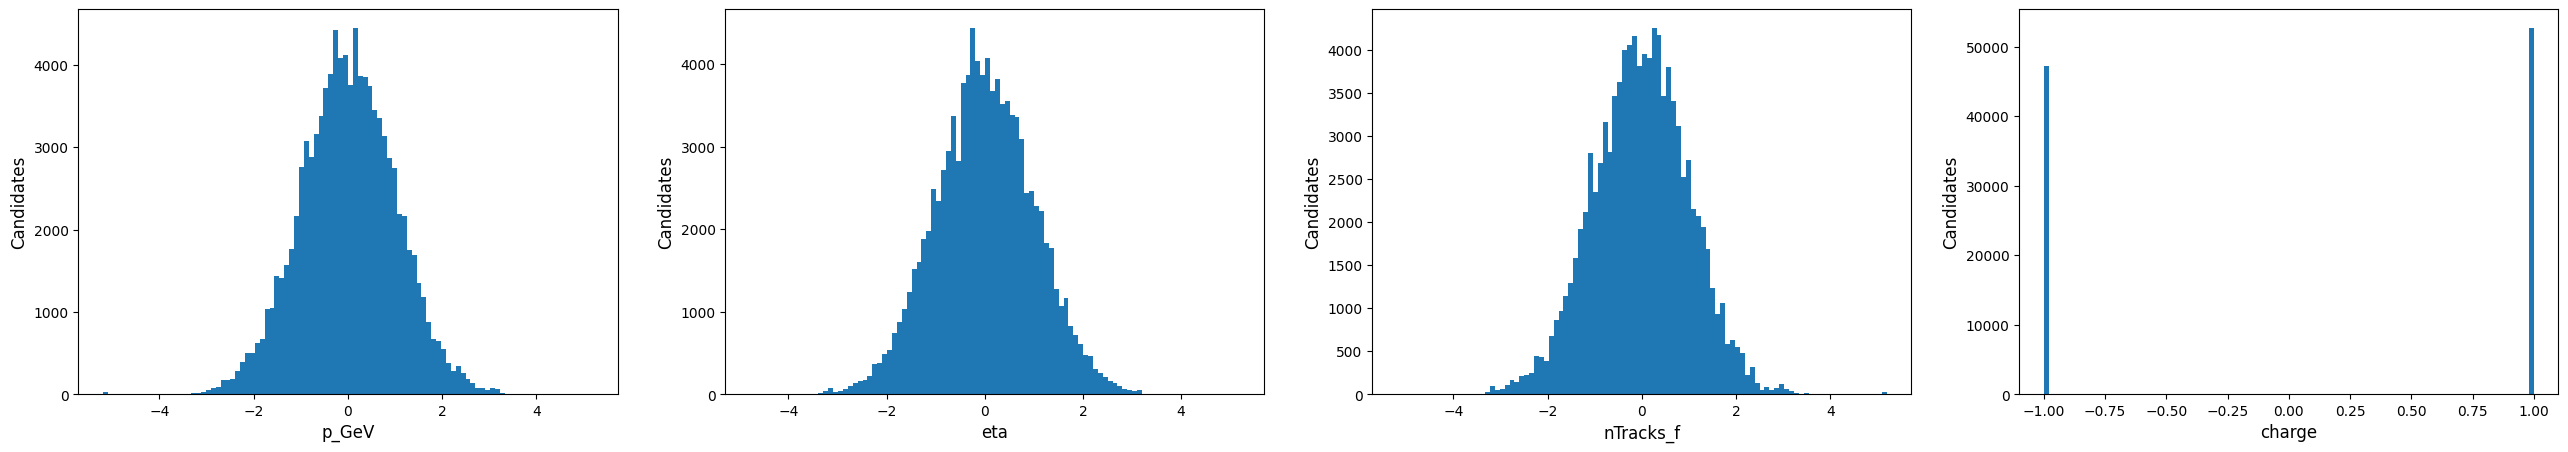

In [35]:
plt.figure(figsize=(32, 5), dpi=100)

for i, x_var in enumerate(features):
    plt.subplot(1, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_p[:, i].numpy()[:100000], bins=100)

plt.show()

In [36]:
np.savez_compressed(
    file=f"{DATA_PATH}/isMuon-proton-{SAMPLE}-trainset.npz",
    x=X_p.numpy(),
    x_vars=features,
    y=y_p.numpy(),
    y_vars=labels,
    w=None,
    w_var=None,
)